## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Nov 28 18:25:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [3]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [4]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.9 MB/s eta 0:00:00


### Download SAM weights

In [5]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [7]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Example Data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [8]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

## Load Model

In [10]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [11]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [12]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [13]:
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Generate masks with SAM

In [14]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [15]:
sam_result

[{'segmentation': array([[False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 234889,
  'bbox': [3, 0, 714, 552],
  'predicted_iou': 1.0237175226211548,
  'point_coords': [[168.75, 100.0]],
  'stability_score': 0.9896397590637207,
  'crop_box': [0, 0, 720, 1280]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 141019,
  'bbox': [75, 252, 545, 

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [16]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

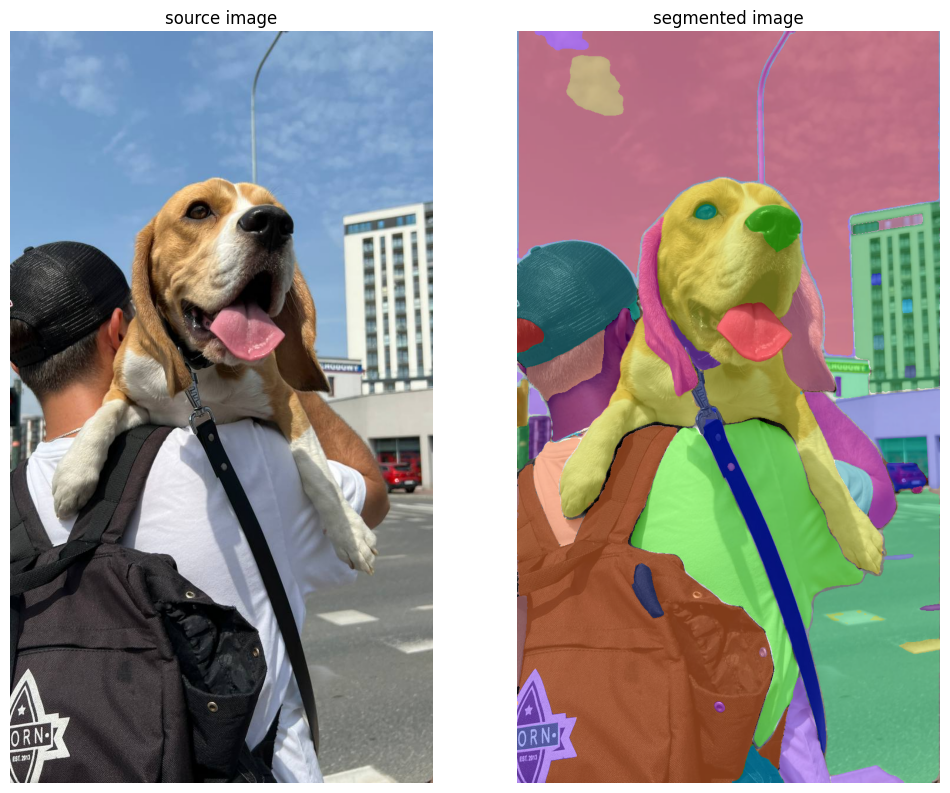

In [17]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

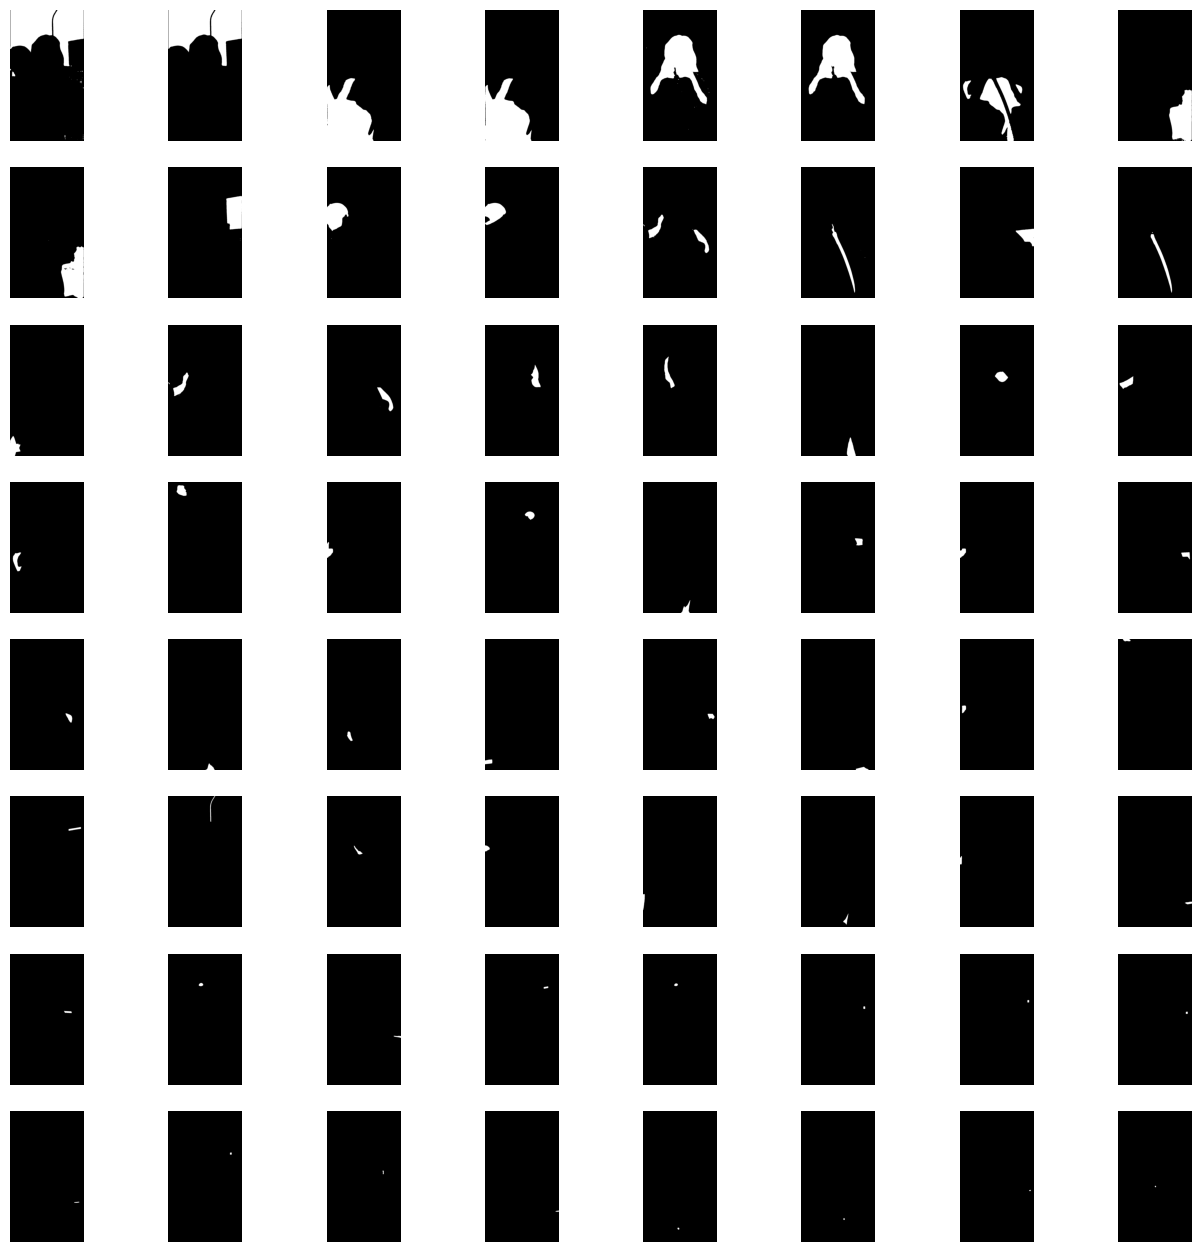

In [15]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [18]:
mask_predictor = SamPredictor(sam)

In [20]:
import os

IMAGE_NAME = "dog-4.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Draw Box



In [21]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [28]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [29]:
widget.bboxes

[{'x': 244, 'y': 386, 'width': 240, 'height': 227, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [30]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 244, 'y': 386, 'width': 240, 'height': 227, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [31]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

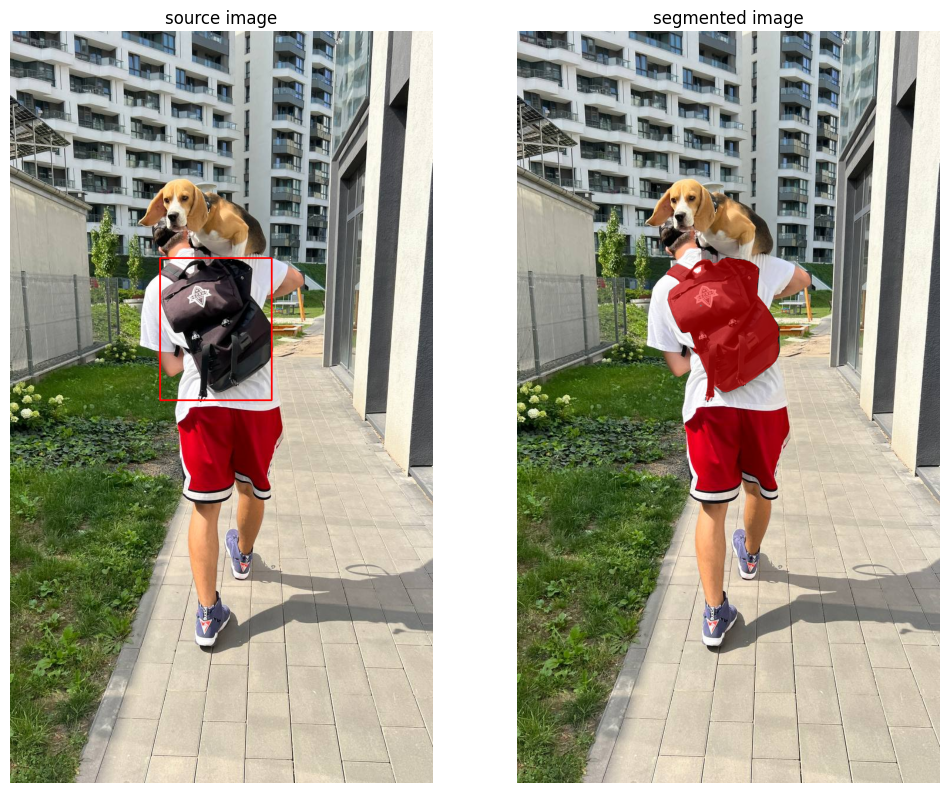

In [32]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

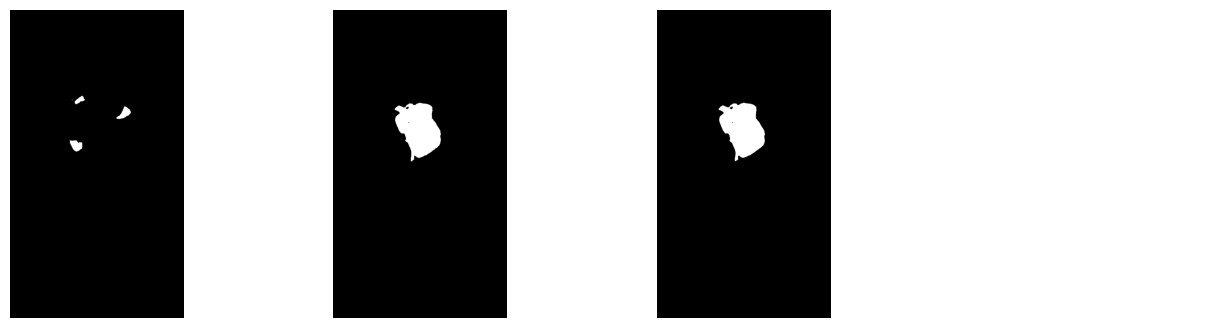

In [33]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

## Segment Anything in Roboflow Universe Dataset